In [361]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from down_baffles3 import RectBaffle, TriangleBaffle, BaffleOptimizer

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


3.0535705921189 0.9833620243815318
Expected baffle area: 3.00, actual baffle area: 3.05, difference: 1.79%
Expected baffle width: 1.00 inches, actual baffle width: 0.98, difference: -1.66%
Actual baffle thermal resistance: 3.10, actual baffle mass: 0.0061, actual baffle efficiency: 497.31 

6.3925077465553395 1.8957980890262427
Expected baffle area: 6.00, actual baffle area: 6.39, difference: 6.54%
Expected baffle width: 2.00 inches, actual baffle width: 1.90, difference: -5.21%
Actual baffle thermal resistance: 3.36, actual baffle mass: 0.0115, actual baffle efficiency: 556.69 

10.189968371508666 2.734238291477403
Expected baffle area: 9.00, actual baffle area: 10.19, difference: 13.22%
Expected baffle width: 3.00 inches, actual baffle width: 2.73, difference: -8.86%
Actual baffle thermal resistance: 3.70, actual baffle mass: 0.0173, actual baffle efficiency: 584.28 

14.52872263352977 3.5195933356720617
Expected baffle area: 12.00, actual baffle area: 14.53, difference: 21.07%
Expec

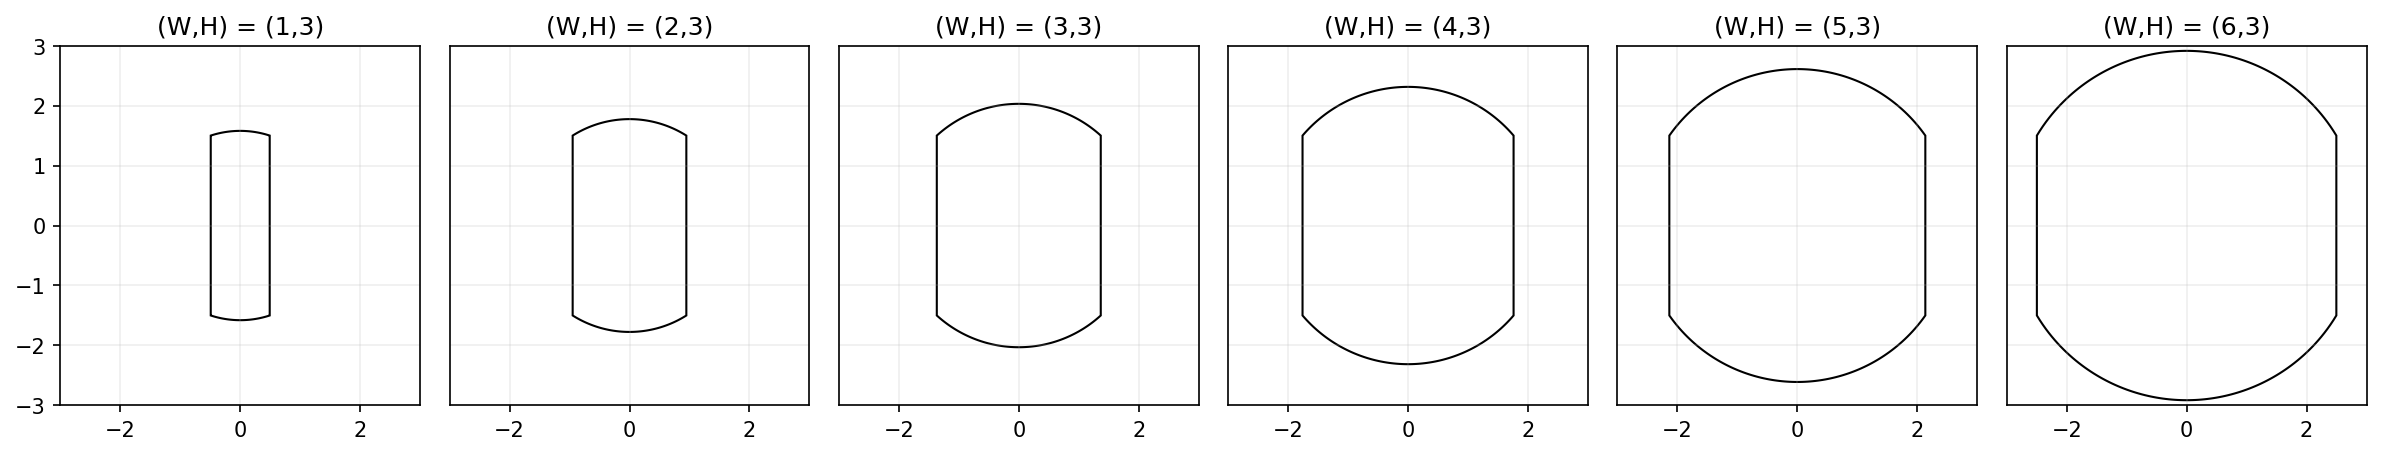

In [470]:
H = 3
top_fabric = .9
bottom_fabric = .9
baffle_fabric = .5
down_fp = 850

baffle_id = 'rect'
if baffle_id == 'tri':
    baffle_type = TriangleBaffle
elif baffle_id == 'rect':
    baffle_type = RectBaffle

n_plots = 6
fig, ax = plt.subplots(1, n_plots, figsize=(16, 4), dpi=150, sharey=True)

Ws = np.linspace(1, 6, n_plots)

for i, w in enumerate(Ws):
    baffle = baffle_type(w, H, top_fabric, bottom_fabric, baffle_fabric, down_fp)
    area = baffle.area
    width = baffle.width
    print(area, width)
    print(f"Expected baffle area: {(w*H):.2f}, actual baffle area: {area:.2f}, difference: {((area-w*H)/(w*H)*100):.2f}%")
    print(f"Expected baffle width: {w:.2f} inches, actual baffle width: {width:.2f}, difference: {((width-w)/w*100):.2f}%")
    #print(f"Relative down thermal efficiency: {(baffle.down_efficiency*100):.2f}% \n")
    print(f"Actual baffle thermal resistance: {baffle.thermal_res*baffle.width:.2f}, actual baffle mass: {baffle.mass:.4f}, "
          f"actual baffle efficiency: {baffle.abs_efficiency:.2f} \n")
    lim = 3
    ax[i].add_patch(baffle.polygon())
    ax[i].set_xlim([-lim, lim])
    ax[i].set_ylim([-lim, lim])
    ax[i].set_title(f"(W,H) = ({int(w)},{H})")
    ax[i].grid(True, alpha=0.2)
    ax[i].set_aspect('equal')
    if i>0:
        ax[i].tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            right=False,         # ticks along the top edge are off
            labelleft=False) # labels along the bottom edge are off
        
plt.tight_layout()
plt.show()

In [471]:
wide = np.linspace(0.1, 6, 100)
if baffle_id == 'tri':
    heights = [1, 2, 3, 4]
elif baffle_id == 'rect':
    heights = [0.05, 0.5, 1, 2, 3, 4]
absolute = []
widths = []
areas = []
for h in heights:
    absolute.append([baffle_type(w, h, top_fabric, bottom_fabric, baffle_fabric, down_fp).abs_efficiency for w in wide])
    widths.append([baffle_type(w, h, top_fabric, bottom_fabric, baffle_fabric, down_fp).width/w for w in wide])
    areas.append([baffle_type(w, h, top_fabric, bottom_fabric, baffle_fabric, down_fp).area/(w*h) for w in wide])

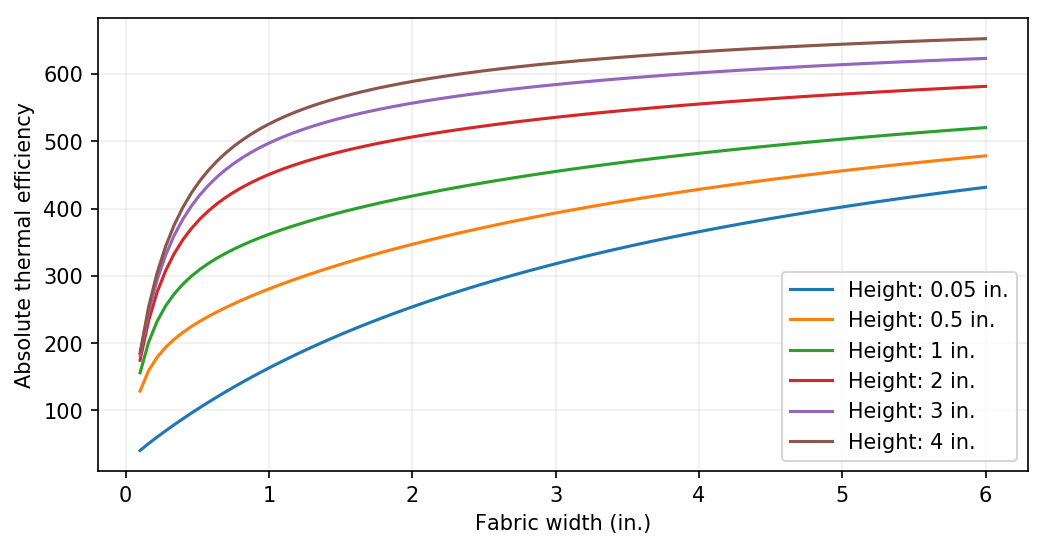

In [472]:
fig, ax = plt.subplots(1, 1, figsize=(8,4), dpi=150)
for h,d in zip(heights, absolute):
    plt.plot(wide, d, label=f"Height: {h} in.")
plt.legend()
plt.grid(True, alpha=0.2)
plt.xlabel("Fabric width (in.)")
plt.ylabel("Absolute thermal efficiency")
plt.show()

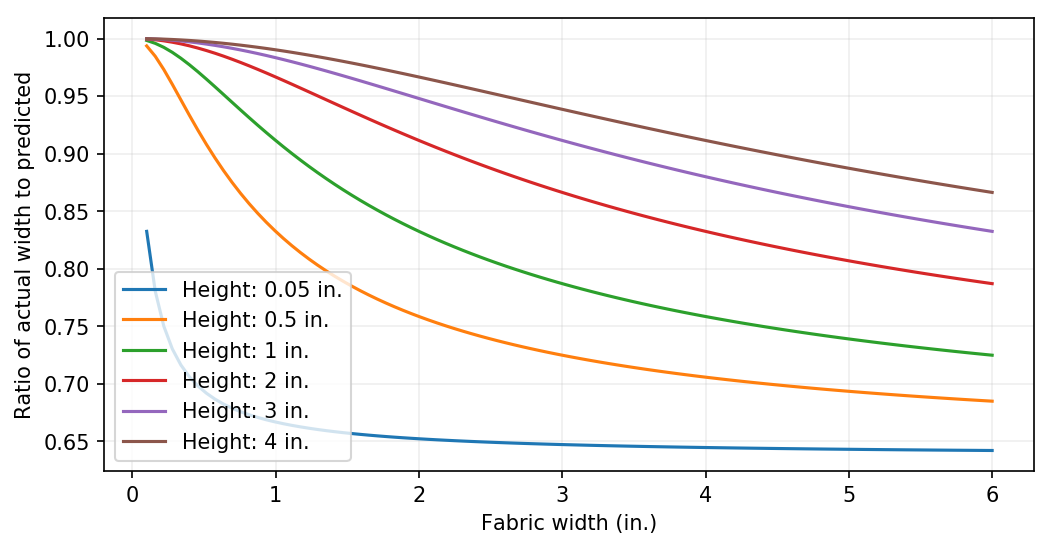

In [473]:
fig, ax = plt.subplots(1, 1, figsize=(8,4), dpi=150)
for h,d in zip(heights, widths):
    plt.plot(wide, d, label=f"Height: {h} in.")
plt.legend()
plt.grid(True, alpha=0.2)
plt.xlabel("Fabric width (in.)")
plt.ylabel("Ratio of actual width to predicted")
plt.show()

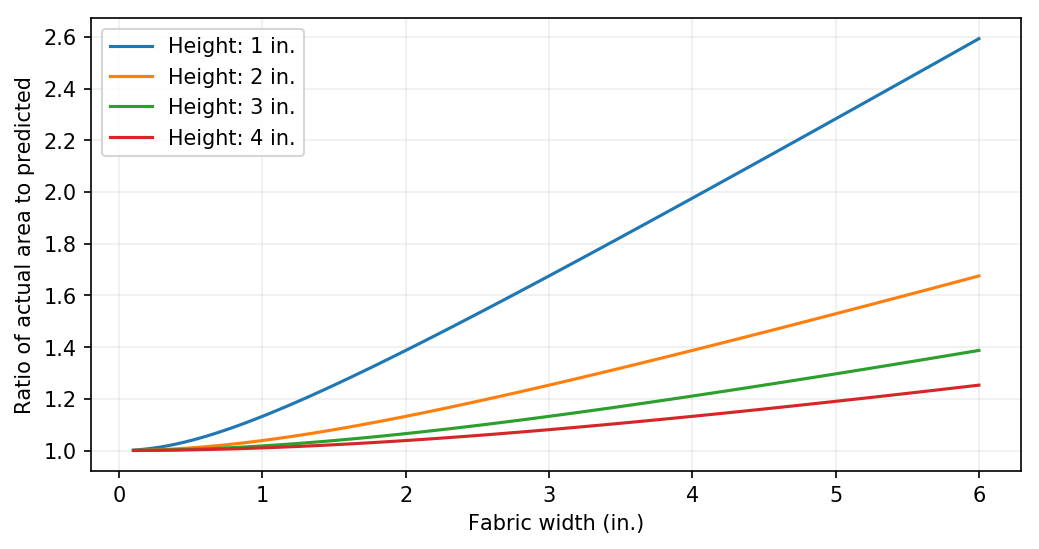

In [474]:
fig, ax = plt.subplots(1, 1, figsize=(8,4), dpi=150)
dat = zip(heights, areas)
next(dat)
next(dat)
for h,d in dat:
    plt.plot(wide, d, label=f"Height: {h} in.")
plt.legend()
plt.grid(True, alpha=0.2)
plt.xlabel("Fabric width (in.)")
plt.ylabel("Ratio of actual area to predicted")
plt.show()

In [475]:
from scipy.optimize import fmin

Nw = 200
Nh = 100

eff = np.zeros((Nw, Nh))
res = np.zeros((Nw, Nh))

for i,w in enumerate(np.linspace(1, 6, Nw)):
    for j,h in enumerate(np.linspace(1, 5, Nh)):
        baffle = RectBaffle(w, h, top_fabric, bottom_fabric, baffle_fabric, down_fp)
        eff[i,j] = baffle.abs_efficiency
        res[i,j] = baffle.thermal_res*baffle.width

I want to find where the lines of constant thermal resistance are maximized with respect to efficiency. I can probably do this by pairing each res value with its eff value and then doing some clever binning to find the best set of w,h params.

Alternatively, the contours of constant thermal resistance are good functions, so I can just iterate over width, and optimize height to get the desired resistance. Then I can look at this line of constant resistance and the w,h values along it and find the point of maximum efficiency.

In [476]:
num_samples = 100
if baffle_id == 'tri':
    target_thermal_resistance = np.array([2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5])
    width_starts = np.linspace(.2, 2, len(target_thermal_resistance))
    width_stops  = np.linspace(4, 9, len(target_thermal_resistance))
elif baffle_id == 'rect':
    target_thermal_resistance = np.array([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5])
    width_starts = np.linspace(.8, 3, len(target_thermal_resistance))
    width_stops  = np.linspace(2, 7, len(target_thermal_resistance))
summary_data = []
efficiency_data = []

def error(h):
    baffle = baffle_type(w, h, top_fabric, bottom_fabric, baffle_fabric, down_fp)
    return abs(thermal_res - baffle.thermal_res*baffle.width)

for thermal_res, start, stop in zip(target_thermal_resistance, width_starts, width_stops):
    print(f"Target thermal resistance: {thermal_res}")
    
    ws = np.linspace(start, stop, num_samples)
    hs = []
    for w in ws:
        hs.append(fmin(error, thermal_res/2, disp=False)[0])
        

    efficiencies = [baffle_type(w, h, top_fabric, bottom_fabric, baffle_fabric, down_fp).abs_efficiency
            for w,h in zip(ws, hs)]
    
    max_eff_idx = np.argmax(efficiencies)
    baffle = baffle_type(ws[max_eff_idx], hs[max_eff_idx], top_fabric,  bottom_fabric, baffle_fabric, down_fp)
    print(f" res = {baffle.thermal_res*baffle.width}, "
          f"(w,h) = ({ws[max_eff_idx]:.2f},{hs[max_eff_idx]:.2f}), "
          f"idx,max = {max_eff_idx}, {efficiencies[max_eff_idx]}, mass = {baffle.mass}")
    summary_data.append([max_eff_idx, efficiencies[max_eff_idx], ws[max_eff_idx], hs[max_eff_idx], baffle.thermal_res, baffle.mass])
    efficiency_data.append([ws, efficiencies])
    
    
summary_data = np.array(summary_data).T

Target thermal resistance: 1.0
 res = 0.9999661269306802, (w,h) = (1.05,0.70), idx,max = 21, 322.74049957167045, mass = 0.0028312440469579533
Target thermal resistance: 1.5
 res = 1.5000206129555722, (w,h) = (1.53,1.08), idx,max = 32, 405.7655842744548, mass = 0.004944969269831134
Target thermal resistance: 2.0
 res = 2.0000347766538242, (w,h) = (1.97,1.47), idx,max = 37, 465.7497555433017, mass = 0.007440227823144719
Target thermal resistance: 2.5
 res = 2.500021746237666, (w,h) = (2.42,1.86), idx,max = 41, 511.16309138129026, mass = 0.010436492916356484
Target thermal resistance: 3.0
 res = 2.999997720184463, (w,h) = (2.86,2.25), idx,max = 44, 546.7574523889357, mass = 0.013910628497683703
Target thermal resistance: 3.5
 res = 3.500028119510371, (w,h) = (3.25,2.67), idx,max = 44, 575.4274907910814, mass = 0.01758002699485839
Target thermal resistance: 4.0
 res = 4.000033198014975, (w,h) = (3.66,3.07), idx,max = 45, 599.0234939731192, mass = 0.02181561535256852
Target thermal resistan

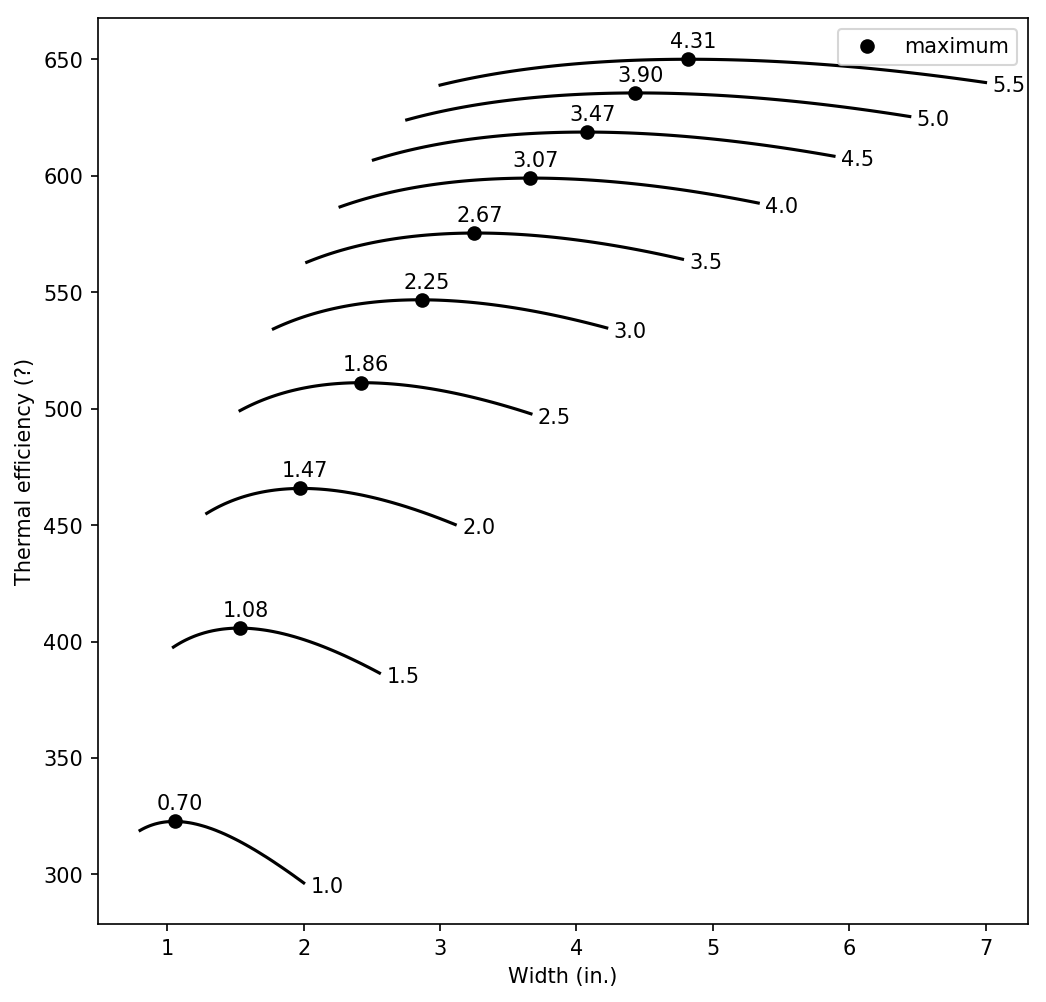

In [477]:
fig, ax = plt.subplots(1, 1, figsize=(8,8), dpi=150)

for i, ((ws, efficiencies), thermal_res, stop) in enumerate(zip(efficiency_data, target_thermal_resistance, width_stops)):
    ax.plot(ws, efficiencies, 'k')
    ax.text(stop+.05, efficiencies[-1]-4, f"{thermal_res}")
    ax.text(summary_data[2,i]-.13, summary_data[1,i]+5, f"{summary_data[3,i]:.2f}")    

ax.plot(summary_data[2], summary_data[1], 'ko', label='maximum')
plt.xlabel("Width (in.)")
plt.ylabel("Thermal efficiency (?)")
plt.legend()
plt.show()

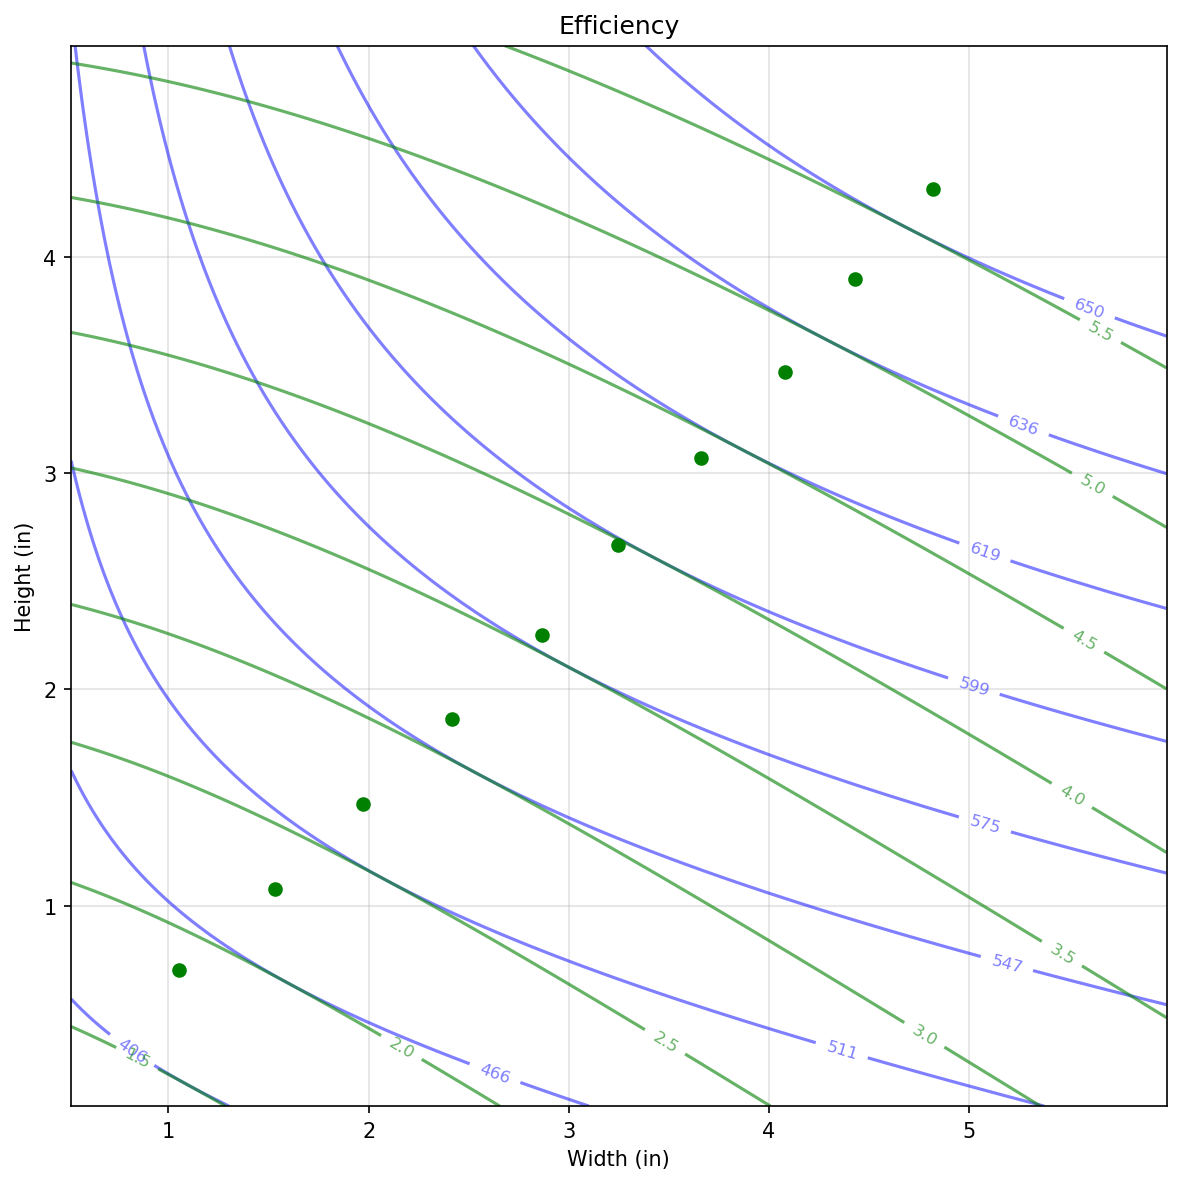

In [478]:
fig, ax = plt.subplots(1, 1, figsize=(8,8), dpi=150)

#im1 = ax.contour(eff.T, levels=np.arange(250,650,50), colors='b', alpha=.5, origin='lower', extent=(1, 10, .05, 5))
im1 = ax.contour(eff.T, levels=summary_data[1], colors='b', alpha=.5, origin='lower', extent=(.5, 6, .05, 5))
#locations = [(2,.3),(2.4,.5),(2.7,.7),(3,1),(3.4,1.4),(4,1.9),(5,2.5),(6,3.4),(8,4.5)]
#ax.clabel(im1, inline=1, colors='k', fontsize=8, manual=locations, fmt='%1.0f', inline_spacing=8)
ax.clabel(im1, inline=1, colors='b', fontsize=8, fmt='%1.0f', inline_spacing=8)
ax.set_title("Efficiency")
ax.set_xlabel("Width (in)")
ax.set_ylabel("Height (in)")

#im2 = ax.contour(res.T, levels=np.arange(1,7.5,.5), cmap='jet', origin='lower', extent=(1, 10, .05, 5))
im2 = ax.contour(res.T, levels=np.arange(.5,6.0,.5), colors='g', alpha=.6, origin='lower', extent=(.5, 6, .05, 5))
ax.clabel(im2, inline=1, fontsize=8, fmt='%1.1f')

plt.grid(True, which='both', linewidth=1, alpha=0.3)

ax.plot(summary_data[2], summary_data[3], 'go')

plt.tight_layout()
plt.show()

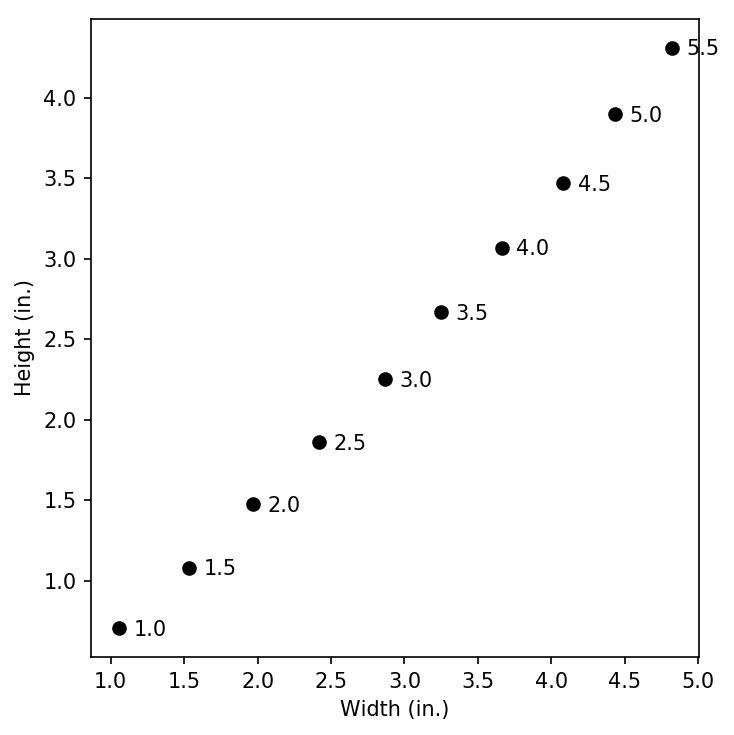

In [479]:
fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi=150)
plt.plot(summary_data[2], summary_data[3], 'ko')
for i,line in enumerate(summary_data.T):
    if i < 10:
        plt.text(line[2]+.1, line[3]-.048, str((target_thermal_resistance[i])))
    else:
        plt.text(line[2]-.32, line[3]-.048, str((target_thermal_resistance[i])))
plt.xlabel("Width (in.)")
plt.ylabel("Height (in.)")
plt.tight_layout()
plt.show()

In [480]:
summary_data.T

array([[2.10000000e+01, 3.22740500e+02, 1.05454545e+00, 7.04785156e-01,
        1.09430858e+00, 2.83124405e-03],
       [3.20000000e+01, 4.05765584e+02, 1.53288440e+00, 1.07958984e+00,
        1.12138734e+00, 4.94496927e-03],
       [3.70000000e+01, 4.65749756e+02, 1.96992144e+00, 1.47275391e+00,
        1.15434659e+00, 7.44022782e-03],
       [4.10000000e+01, 5.11163091e+02, 2.41683502e+00, 1.86120605e+00,
        1.17158419e+00, 1.04364929e-02],
       [4.40000000e+01, 5.46757452e+02, 2.86419753e+00, 2.24934082e+00,
        1.18331504e+00, 1.39106285e-02],
       [4.40000000e+01, 5.75427491e+02, 3.24691358e+00, 2.66575928e+00,
        1.21096871e+00, 1.75800270e-02],
       [4.50000000e+01, 5.99023494e+02, 3.66060606e+00, 3.06835938e+00,
        1.22437899e+00, 2.18156154e-02],
       [4.60000000e+01, 6.18786470e+02, 4.08058361e+00, 3.46810913e+00,
        1.23352776e+00, 2.65299577e-02],
       [4.50000000e+01, 6.35589849e+02, 4.43232323e+00, 3.89703369e+00,
        1.25657595e+00, 

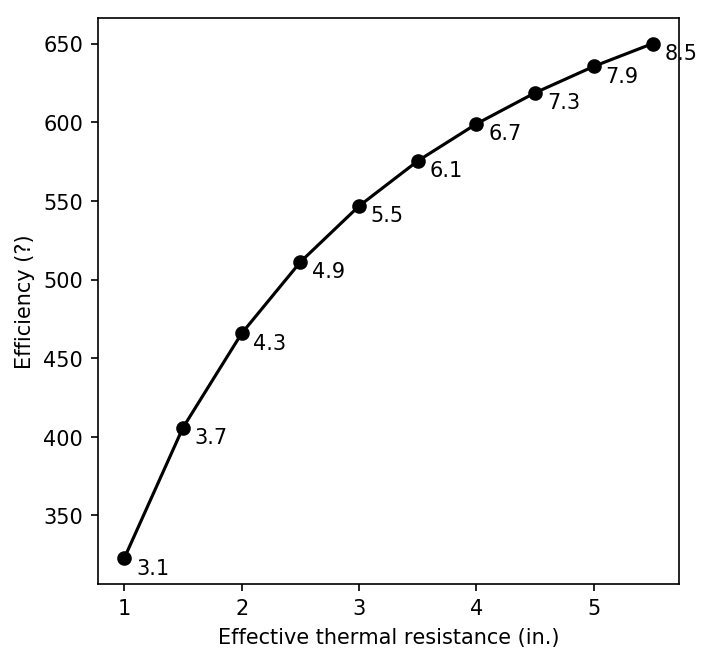

In [481]:
if baffle_id == 'tri':
    tri_eff_dat = summary_data[1]
elif baffle_id == 'rect':
    rect_eff_dat = summary_data[1]

fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi=150)
plt.plot(target_thermal_resistance, summary_data[1], 'ko-', label='heavy')
for i, thermal_res in enumerate(target_thermal_resistance):
    baffle = RectBaffle(summary_data[2,i], summary_data[3,i], top_fabric,  bottom_fabric, baffle_fabric, down_fp)
    plt.text(thermal_res+.1, summary_data[1,i]-10, f"{baffle.mass/baffle.width*1000:.1f}")
plt.xlabel("Effective thermal resistance (in.)")
plt.ylabel("Efficiency (?)")
#plt.legend()
plt.show()

The above plot could use lines of constant width and lines of constant height kinda like the atmospheric plot things that are super confusing.

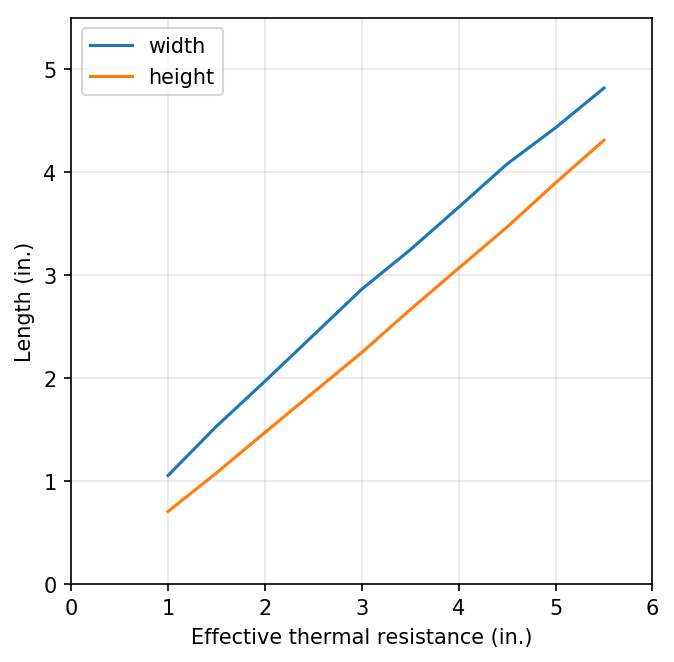

In [482]:
fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi=150)
plt.plot(target_thermal_resistance, summary_data[2], label='width')
plt.plot(target_thermal_resistance, summary_data[3], label='height')
plt.xlabel("Effective thermal resistance (in.)")
plt.ylabel("Length (in.)")
plt.xlim([0, 6])
plt.ylim([0, 5.5])
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

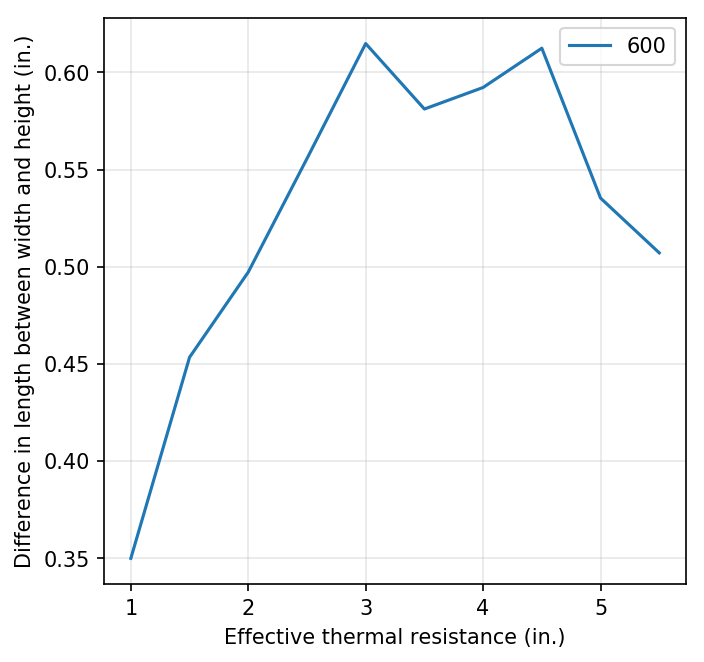

In [483]:
fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi=150)
plt.plot(target_thermal_resistance, summary_data[2]-summary_data[3], label='600')
plt.grid(True, alpha=0.3)
plt.xlabel("Effective thermal resistance (in.)")
plt.ylabel("Difference in length between width and height (in.)")
plt.legend()
plt.show()

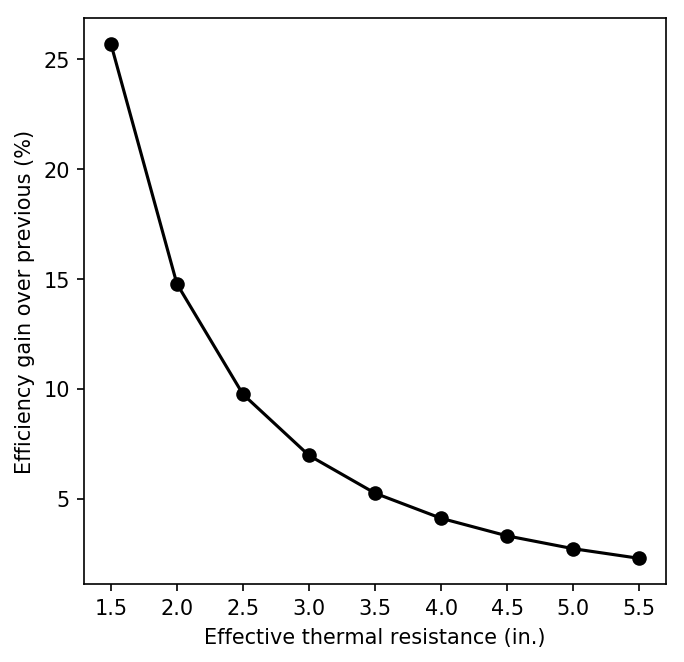

In [484]:
fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi=150)
gain = (summary_data[1,1:]-summary_data[1,:-1])/(summary_data[1,:-1])*100
plt.plot(target_thermal_resistance[1:], gain, 'ko-', label='heavy')
plt.xlabel("Effective thermal resistance (in.)")
plt.ylabel("Efficiency gain over previous (%)")
#plt.legend()
plt.show()

In [485]:
target_thermal_resistance = np.array([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5])
width_stops  = np.linspace(2, 7, len(target_thermal_resistance))
width_starts = np.linspace(.8, 3, len(target_thermal_resistance))
width_ints = [(start, stop) for start,stop in zip(width_starts, width_stops)]

baffle_fabric = 0

downs = [900, 800, 700, 600]
fp_data_p66 = []

for fp in downs:
    baffle_opt = BaffleOptimizer('rect', .66, .66, baffle_fabric, fp)
    summ, effs = baffle_opt.summary_analysis(target_thermal_resistance, width_ints, num_samples=25)
    fp_data_p66.append([fp, summ])

In [486]:
fp_data_1p3 = []

for fp in downs:
    baffle_opt = BaffleOptimizer('rect', 1.3, 1.3, baffle_fabric, fp)
    summ, effs = baffle_opt.summary_analysis(target_thermal_resistance, width_ints, num_samples=25)
    fp_data_1p3.append([fp, summ])

In [487]:
faces = [.66, 1.1, 1.3, 1.7, 1.9]
face_data_800 = []

for face in faces:
    baffle_opt = BaffleOptimizer('rect', face, face, baffle_fabric, 800)
    summ, effs = baffle_opt.summary_analysis(target_thermal_resistance, width_ints, num_samples=25)
    face_data_800.append([face, summ])

In [488]:
face_data_600 = []

for face in faces:
    baffle_opt = BaffleOptimizer('rect', face, face, baffle_fabric, 600)
    summ, effs = baffle_opt.summary_analysis(target_thermal_resistance, width_ints, num_samples=25)
    face_data_600.append([face, summ])

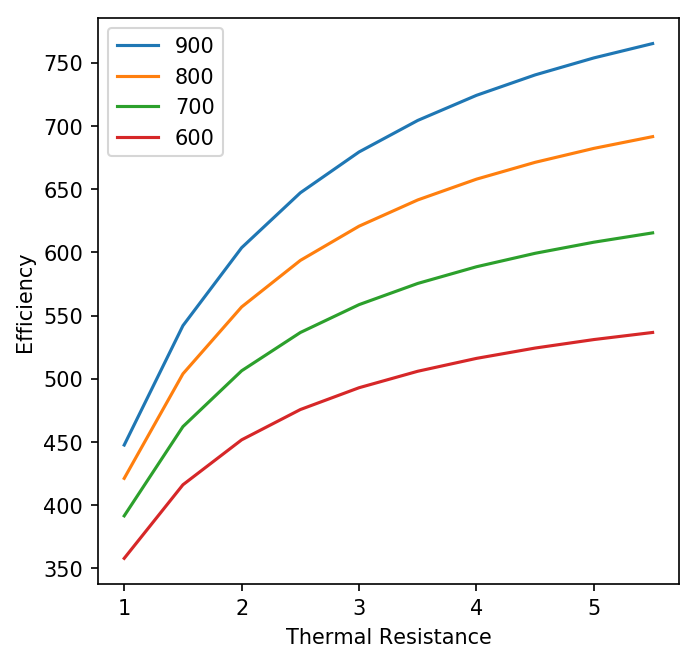

In [489]:
fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi=150)
for (fp, summ) in fp_data_p66:
    plt.plot(summ.actual_thermal_res.values, summ.efficiency.values, label=str(fp))
    
plt.xlabel('Thermal Resistance')
plt.ylabel('Efficiency')
plt.legend()
plt.show()

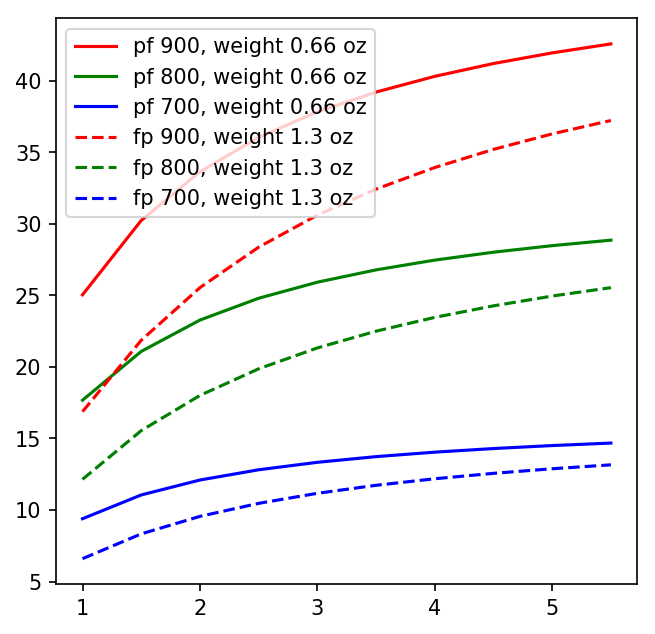

In [490]:
fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi=150)
colors = ['r', 'g', 'b', 'y']
for i in range(3):
    plt.plot(summ.actual_thermal_res.values,
             (fp_data_p66[i][1].efficiency.values-fp_data_p66[-1][1].efficiency.values)/fp_data_p66[-1][1].efficiency.values*100, 
             color=colors[i], linestyle='-', label=f"pf {fp_data_p66[i][0]}, weight {0.66} oz")
    
for i in range(3):
    plt.plot(summ.actual_thermal_res.values,
             (fp_data_1p3[i][1].efficiency.values-fp_data_1p3[-1][1].efficiency.values)/fp_data_1p3[-1][1].efficiency.values*100,
             color=colors[i], linestyle='--', label=f"fp {fp_data_1p3[i][0]}, weight {1.3} oz")

plt.legend()
plt.show()

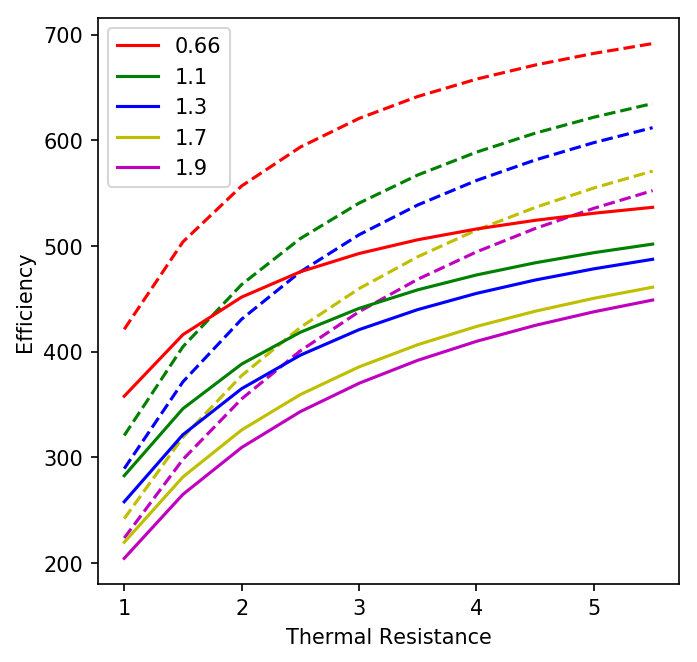

In [491]:
fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi=150)
colors = ['r', 'g', 'b', 'y', 'm']
for (face, summ), color in zip(face_data_800, colors):
    plt.plot(summ.actual_thermal_res.values, summ.efficiency.values,
            color=color, linestyle='--')
    
for (face, summ), color in zip(face_data_600, colors):
    plt.plot(summ.actual_thermal_res.values, summ.efficiency.values, label=str(face),
            color=color, linestyle='-')

plt.xlabel('Thermal Resistance')
plt.ylabel('Efficiency')    
plt.legend()
plt.show()

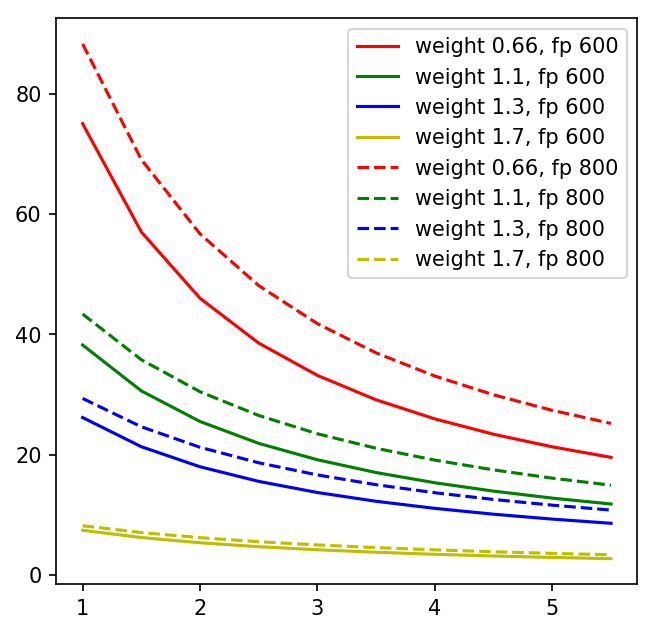

In [492]:
fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi=150)
colors = ['r', 'g', 'b', 'y', 'm']
for i in range(4):
    plt.plot(summ.actual_thermal_res.values,
             (face_data_600[i][1].efficiency.values-face_data_600[-1][1].efficiency.values)/face_data_600[-1][1].efficiency.values*100, 
             color=colors[i], linestyle='-', label=f"weight {face_data_600[i][0]}, fp {600}")
    
for i in range(4):
    plt.plot(summ.actual_thermal_res.values,
             (face_data_800[i][1].efficiency.values-face_data_800[-1][1].efficiency.values)/face_data_800[-1][1].efficiency.values*100,
             color=colors[i], linestyle='--', label=f"weight {face_data_800[i][0]}, fp {800}")

plt.legend()
plt.show()

# Triangles

Triangular baffles don't work better than rectangular baffles!

In [467]:
from down_baffles3 import TriangleBaffle, RectBaffle

w = 4.5
h = 3
top_fabric = 1.0
bottom_fabric = 1.0
baffle_fabric = 0.6
down_fp = 700
bafflet = TriangleBaffle(9, 3, top_fabric, bottom_fabric, baffle_fabric, down_fp)
baffler = RectBaffle(4.4, 3.9, top_fabric, bottom_fabric, baffle_fabric, down_fp)

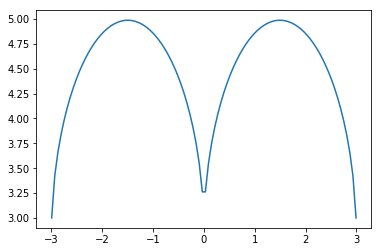

In [468]:
x = np.linspace(-bafflet.width/2, bafflet.width/2, 100)
h = bafflet._baffle_height(x)
plt.plot(x, h)
plt.show()

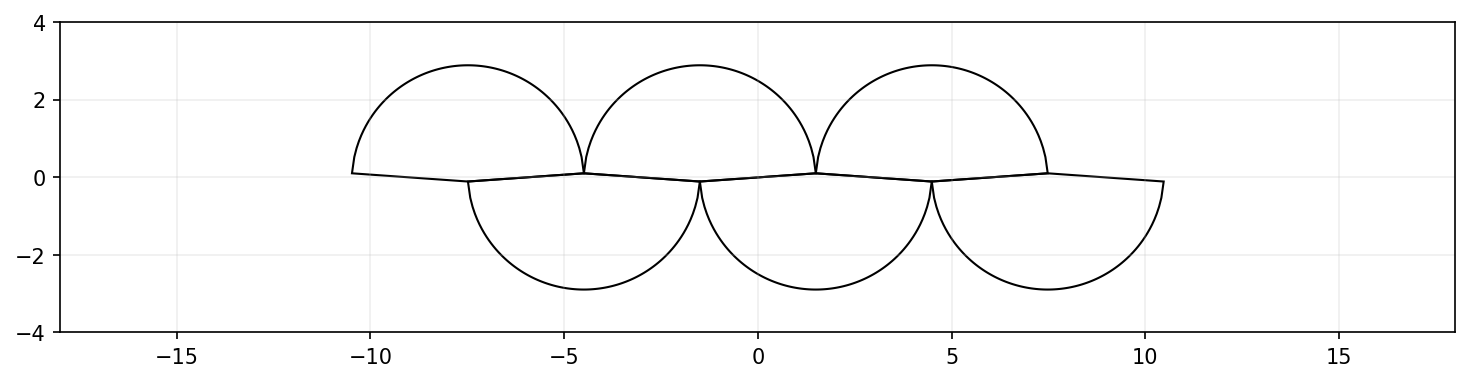

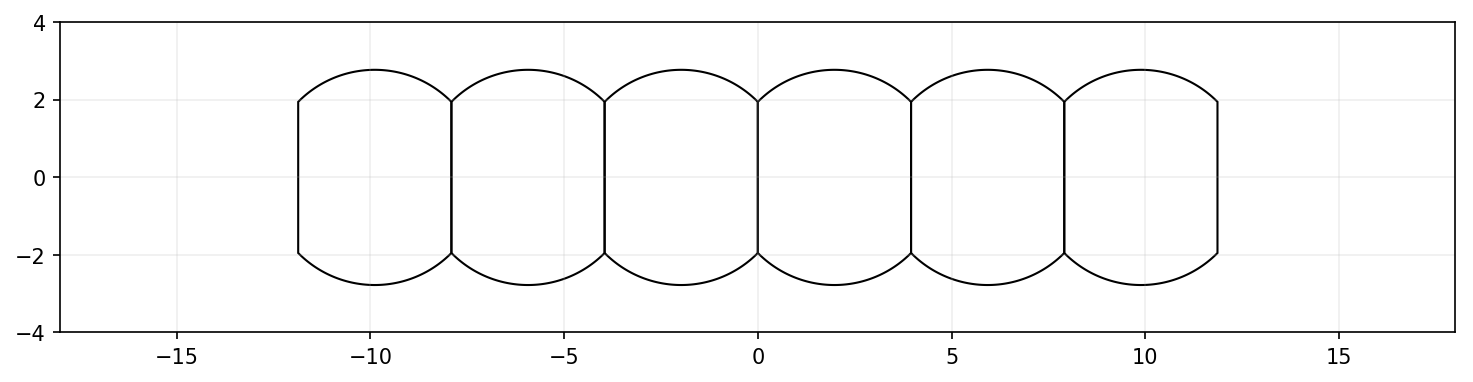

In [469]:
quiltt = bafflet.quilt(6)
quiltr = baffler.quilt(6)

xlim = 18
ylim = 4

fig, ax = plt.subplots(1, 1, figsize=(12, 4), dpi=150)
for baff in quiltt:
    ax.add_patch(baff)
plt.xlim([-xlim, xlim])
plt.ylim([-ylim, ylim])
ax.grid(True, alpha=0.2)
ax.set_aspect('equal')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(12, 4), dpi=150)
for baff in quiltr:
    ax.add_patch(baff)
plt.xlim([-xlim, xlim])
plt.ylim([-ylim, ylim])
ax.grid(True, alpha=0.2)
ax.set_aspect('equal')
plt.show()

In [418]:
baffs = [bafflet, baffler]
for baf in baffs:
    print(f"{baf.thermal_res:.2F}, {baf.width:2F}, {baf.thermal_res*baf.width:2F}, {baf.mass:3F}, {baf.abs_efficiency:.1F}")


0.79, 6.315281, 4.978530, 0.059969, 524.3
1.26, 3.953930, 4.990670, 0.037065, 532.4


In [433]:
top_fabric = .75
bottom_fabric = .66
baffle_fabric = .5
down_fp = 900

baffle_id = 'tri'
if baffle_id == 'tri':
    baffle_type = TriangleBaffle
elif baffle_id == 'rect':
    baffle_type = RectBaffle

num_samples = 100
if baffle_id == 'tri':
    target_thermal_resistance = np.array([2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5])
    width_starts = np.linspace(.2, 2, len(target_thermal_resistance))
    width_stops  = np.linspace(4, 9, len(target_thermal_resistance))
elif baffle_id == 'rect':
    target_thermal_resistance = np.array([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5])
    width_starts = np.linspace(.8, 3, len(target_thermal_resistance))
    width_stops  = np.linspace(2, 7, len(target_thermal_resistance))
summary_data = []
efficiency_data = []

def error(h):
    baffle = baffle_type(w, h, top_fabric, bottom_fabric, baffle_fabric, down_fp)
    return abs(thermal_res - baffle.thermal_res*baffle.width)

for thermal_res, start, stop in zip(target_thermal_resistance, width_starts, width_stops):
    print(f"Target thermal resistance: {thermal_res}")
    
    ws = np.linspace(start, stop, num_samples)
    hs = []
    for w in ws:
        hs.append(fmin(error, thermal_res/2, disp=False)[0])
        

    efficiencies = [baffle_type(w, h, top_fabric, bottom_fabric, baffle_fabric, down_fp).abs_efficiency
            for w,h in zip(ws, hs)]
    
    max_eff_idx = np.argmax(efficiencies)
    baffle = baffle_type(ws[max_eff_idx], hs[max_eff_idx], top_fabric,  bottom_fabric, baffle_fabric, down_fp)
    print(f" res = {baffle.thermal_res*baffle.width}, "
          f"(w,h) = ({ws[max_eff_idx]:.2f},{hs[max_eff_idx]:.2f}), "
          f"idx,max = {max_eff_idx}, {efficiencies[max_eff_idx]}, mass = {baffle.mass}")
    summary_data.append([max_eff_idx, efficiencies[max_eff_idx], ws[max_eff_idx], hs[max_eff_idx], baffle.thermal_res, baffle.mass])
    efficiency_data.append([ws, efficiencies])
    
    
summary_data = np.array(summary_data).T

if baffle_id == 'tri':
    tri_eff_dat = summary_data[1]
elif baffle_id == 'rect':
    rect_eff_dat = summary_data[1]

Target thermal resistance: 2.0
 res = 1.999972008785703, (w,h) = (3.08,1.76), idx,max = 75, 503.56459515855227, mass = 0.010726571158634967
Target thermal resistance: 2.5
 res = 2.500009223741421, (w,h) = (3.85,2.20), idx,max = 79, 552.0185411951564, mass = 0.01530406910110008
Target thermal resistance: 3.0
 res = 2.9999798557900688, (w,h) = (4.62,2.64), idx,max = 82, 589.8499893351398, mass = 0.02060692605854554
Target thermal resistance: 3.5
 res = 3.5000147025174395, (w,h) = (5.52,1.53), idx,max = 87, 629.218621505933, mass = 0.01655348173419462
Target thermal resistance: 4.0
 res = 3.9999675426226964, (w,h) = (6.35,1.77), idx,max = 90, 664.7945868586979, mass = 0.020722171256839225
Target thermal resistance: 4.5
 res = 4.500043113034677, (w,h) = (7.08,1.96), idx,max = 91, 696.5268843772392, mass = 0.02463659215318252
Target thermal resistance: 5.0
 res = 4.9999164217870495, (w,h) = (7.89,2.19), idx,max = 93, 723.1954478982015, mass = 0.02945832729049078
Target thermal resistance: 5

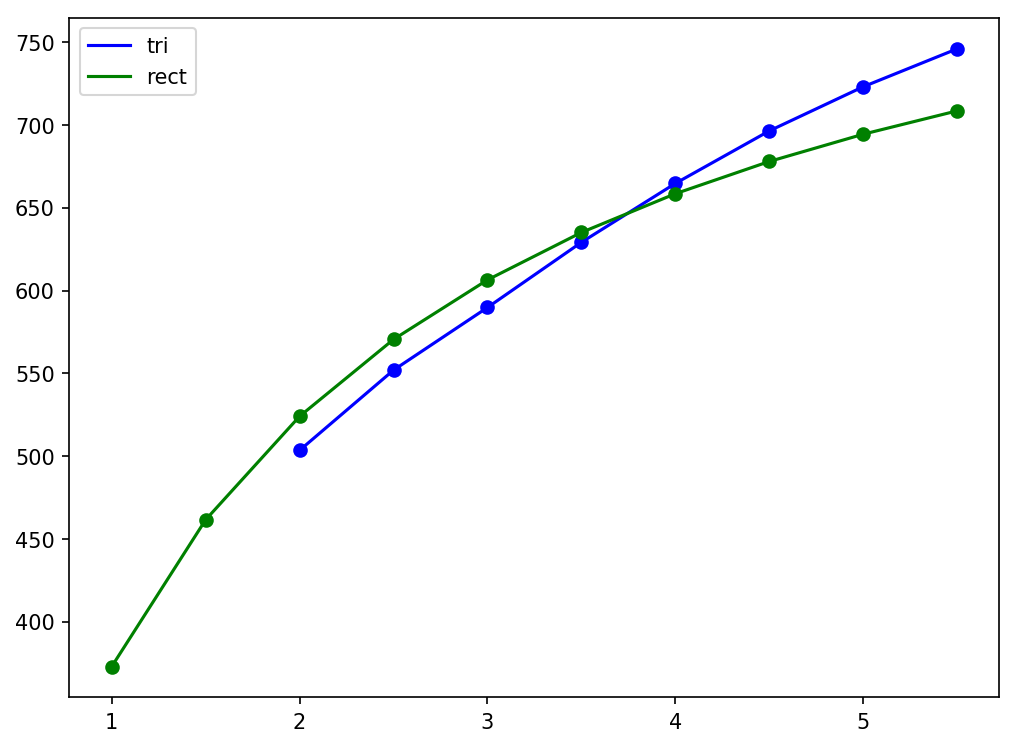

In [436]:
fig, ax = plt.subplots(1, 1, figsize=(8,6), dpi=150)
tri_x = [2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5]
rect_x = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5]
plt.plot(tri_x, tri_eff_dat, 'b-', label='tri')
plt.plot(tri_x, tri_eff_dat, 'bo')
plt.plot(rect_x, rect_eff_dat, 'g-', label='rect')
plt.plot(rect_x, rect_eff_dat, 'go')
plt.legend()
plt.show()